In [5]:
import tensorflow as tf
import numpy as np
import pickle
import pandas
import matplotlib.pyplot as plt
#TODO: read tf documentation on what the static_rnn does
#do I want to one hot encode the data? or already too many dimensions

In [3]:
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [4]:
tf.__version__

'1.12.0'

In [6]:
#open files, they have not been normalized yet
dffile = open('masdfr4m7170317s1.pkl',"rb")
dyfile = open('r4m7170317s1.pkl', "rb")
df = pickle.load(dffile)
dy = pickle.load(dyfile)

In [7]:
print(df) # do I want to take out lastStimT ??

      intensity  pupilPeri  wheelPeri  responseT  whiskPeri  lastStimT  \
0           1.0  28.572136  20.540612   0.417911  18.868394        0.0   
1           1.0  28.502843  22.147099   0.417911  16.260633        0.1   
2           1.0  28.397470  20.402827   0.417911  13.750951        0.2   
3           1.0  28.275008  17.837755   0.417911  13.613636        0.3   
4           1.0  28.259277  10.929228   0.417911  15.728795        0.4   
5           1.0  28.411358   6.836825   0.417911  18.009669        0.5   
6           1.0  28.727576   2.964386   0.417911  18.112827        0.6   
7           1.0  28.953888   5.695584   0.417911  17.157140        0.7   
8           1.0  28.969450   8.156320   0.417911  16.636804        0.8   
9           1.0  28.840834  10.485815   0.417911  16.797964        0.9   
10          1.0  28.814819  10.614280   0.417911  16.164776        1.0   
11          1.0  28.817211   9.009948   0.417911  13.742710        1.1   
12          1.0  28.919805   7.288404 

In [8]:
x_data = df.values
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (2400, 8)


In [11]:
print(type(dy))
print("Shape:", dy.shape)

<class 'numpy.ndarray'>
Shape: (2400, 22360)


In [14]:
num_data = len(x_data)
print(num_data)
train_split = 0.9
num_train = int(train_split*num_data)
print(num_train)
num_test = num_data - num_train
print(num_test)

2400
2160
240


In [15]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

2400

In [16]:
y_train = dy[0:num_train]
y_test = dy[num_train:]
len(y_train) + len(y_test)

2400

In [28]:
num_x_signals = x_data.shape[1]
num_x_signals
num_y_signals = dy.shape[1]
num_y_signals

22360

# Scaled Data

In [19]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -1.0
Max: 29.2668806589132


In [20]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [21]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [22]:
x_test_scaled = x_scaler.transform(x_test)

In [23]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Data Generator
useful for large amounts of data

In [31]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [32]:
batch_size = 40
sequence_length = 20 #20 frames after stim time

In [33]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [34]:
x_batch, y_batch = next(generator)

In [35]:
print(x_batch.shape)
print(y_batch.shape)

(40, 20, 8)
(40, 20, 22360)


In [36]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [37]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [38]:
# squash the outputs to be between 0 and 1
model.add(Dense(num_y_signals, activation='sigmoid'))


A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has temperatures between -20 and +30 degrees, then the scaler-object will map -20 to 0 and +30 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to temperature values between -20 and +30.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid NaN values during training. You may need to experiment with this to get it working.

In [39]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

# Loss Function

In [52]:
warmup_steps = 5

In [53]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [54]:
optimizer = RMSprop(lr=1e-3)

In [55]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         800256    
_________________________________________________________________
dense (Dense)                (None, None, 22360)       11470680  
Total params: 12,270,936
Trainable params: 12,270,936
Non-trainable params: 0
_________________________________________________________________


In [57]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [58]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [59]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [60]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [61]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [62]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 00001: val_loss improved from inf to 0.01949, saving model to 23_checkpoint.keras
100/100 [==============================] - 24s 237ms/step - loss: 0.0219 - val_loss: 0.0195
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0150
Epoch 00002: val_loss did not improve from 0.01949

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 20s 202ms/step - loss: 0.0150 - val_loss: 0.0204
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0130
Epoch 00003: val_loss improved from 0.01949 to 0.01843, saving model to 23_checkpoint.keras
100/100 [==============================] - 20s 204ms/step - loss: 0.0130 - val_loss: 0.0184
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0128
Epoch 00004: val_loss did not improve from 0.01843

Epoch 00004: ReduceLROnPlateau reducing learning ra

In [63]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 100ms/step


In [64]:
print("loss (test-set):", result)

loss (test-set): 0.012694506905972958


In [108]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print(y_pred)
    print(len(y_pred[0]))
    print(len(y_pred[0][0]))
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print(y_pred_rescaled)
    print(len(y_pred_rescaled))
    print(len(y_pred_rescaled[0]))
    # For each output-signal.
    for signal in range(1):
        # Get the output-signal predicted by the model.
        signal_pred = np.sum(np.abs(y_pred_rescaled), axis=0)
        print(signal_pred)
        # Get the true output-signal from the data-set.
        signal_true = np.sum(np.abs(y_true), axis=0)
        print(len(signal_true[400:800]))
        print(signal_true)
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true[400:800], label='true')
        plt.plot(signal_pred[400:800], label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel("sum")
        plt.legend()
        plt.show()

[[[0.5686745  0.5777599  0.57546866 ... 0.596345   0.5927392  0.59697837]]]
1
22360
[[0.00317972 0.00378279 0.00398373 ... 0.00157265 0.0010706  0.00075337]]
1
22360
[0.00317972 0.00378279 0.00398373 ... 0.00157265 0.0010706  0.00075337]
400
[0.00093687 0.00138119 0.00190656 ... 0.00088361 0.00057912 0.00033994]


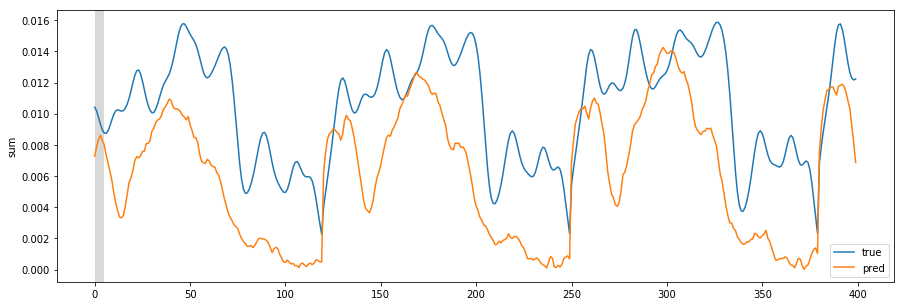

In [109]:
plot_comparison(start_idx=1, length=1, train=True)